In [1]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import pickle
import time 

from resnet import ResNet18

import syft as sy

hook = sy.TorchHook(torch=torch)

%matplotlib inline

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/home/sukhad/pysyft-test/lib/python3.6/site-packages/tf_encrypted-0.6.0rc0-py3.6-linux-x86_64.egg/tf_encrypted/operations/secure_random/secure_random_module_tf_2.0.0.so', error was "/lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.25' not found (required by /home/sukhad/pysyft-test/lib/python3.6/site-packages/tf_encrypted-0.6.0rc0-py3.6-linux-x86_64.egg/tf_encrypted/operations/secure_random/secure_random_module_tf_2.0.0.so)".


In [2]:
BATCH_SIZE = 64
NUM_EPOCH = 350
NUM_CLASS = 10  
#MODEL_PATH = "drive/My Drive/cifar-backdoor/models/cifar-resnet-checkpoint-250ep-False.pt"
NUM_WORKERS = 100
attacker_index = 42

#alpha = 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
with open('/home/sukhad/Workspace/GithHub/backdoor_fl/data/indices.pkl',"rb") as f:
    backdoor_indices = pickle.load(f)

In [4]:
train_transformer = transforms.Compose([transforms.RandomCrop(size=32, padding=4), 
                                        transforms.RandomHorizontalFlip(), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transformer = transforms.Compose([transforms.ToTensor(), 
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.CIFAR10(root="drive/My Drive/cifar-backdoor/", train=True, 
                                          download=True, transform=train_transformer)


benign_data = list()
backdoor_data = list()

_backdoor_ind = list()
for key in backdoor_indices.keys():
    _backdoor_ind += backdoor_indices[key] 

for idx, x in enumerate(train_data):
    if idx in _backdoor_ind:
        tup = (x[0],2)
        backdoor_data.append(tup)
    else:
        benign_data.append(x)

benign_dataloader = torch.utils.data.DataLoader(dataset=benign_data, batch_size=64, 
                                         shuffle=True)

backdoor_dataloader = torch.utils.data.DataLoader(dataset=backdoor_data, batch_size=64, 
                                         shuffle=True)

test_data = torchvision.datasets.CIFAR10(root="drive/My Drive/cifar-backdoor/", train=False, 
                                         download=True, transform=test_transformer)
testloader = torch.utils.data.DataLoader(dataset=test_data, batch_size=64, 
                                         shuffle=True)

labels = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


Files already downloaded and verified
Files already downloaded and verified


In [5]:
def convert_image(img):
    img = img / 2 + 0.5
    img = img.numpy()
    return img.transpose(1,2,0) 


def plot_images(dataloader):
    data, label = next(iter(dataloader))
    ax_dim = 2
    indices = list()
    for i in range(ax_dim**2):
        indices.append(np.random.choice(range(len(data))))
  
    label_list = list()
  
    fig, axes = plt.subplots(ax_dim,ax_dim,figsize=(3,3))
    i = 0
    for j in range(ax_dim):
        for k in range(ax_dim):
            axes[j][k].set_axis_off()
            #print(batch_ind)
            #print(img_ind)
            axes[j][k].imshow(convert_image(data[indices[i]]))
            label_list.append(labels[label[indices[i]]])
            i += 1

  #print(label_list)

benign images


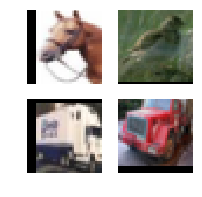

In [6]:
print("benign images")
plot_images(benign_dataloader)  # Normal images

backdoor images


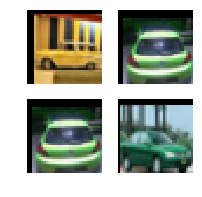

In [7]:
print("backdoor images")
plot_images(backdoor_dataloader)  # backdoor images

In [8]:
# Generate 100 virtual workers
workers = list()
data_dict = dict()

for i in range(NUM_WORKERS):
    workers.append(sy.VirtualWorker(hook=hook, id="worker"+str(i)))
    data_dict["worker"+str(i)] = list()

attacker_worker = workers[attacker_index]

secure_worker = sy.VirtualWorker(hook=hook, id="secure_worker")

In [9]:
# let's distribute the benign training data
for idx, (data, label) in enumerate(benign_dataloader):
    worker = workers[idx % NUM_WORKERS]
    data = data.send(worker)
    label = label.send(worker)

    data_dict[worker.id].append((data, label)) 

In [10]:
# let's distribute the backdoor data
attacker_backdoor_data = list()

attacker_worker = workers[attacker_index]
for data, label in backdoor_data:
    data = data.send(attacker_worker)
    label = torch.tensor(label).send(attacker_worker)

    attacker_backdoor_data.append((data, label))

In [11]:
def replace_data(benign_data, benign_label, attacker_backdoor_data, c=20):
    benign_indices = random.sample(range(64), c)
    backdoor_indices = random.sample(range(64), c)

    for i in range(c):
        benign_data[benign_indices[i]] = attacker_backdoor_data[backdoor_indices[i]][0]
        benign_label[benign_indices[i]] = attacker_backdoor_data[backdoor_indices[i]][1] 

In [12]:
def constraint_and_scale(global_model, worker_model, gamma):
    global_model_copy = global_model.copy().send(worker_model.location)
    
    for key in global_model_copy.layers_dict.keys():
        bias_none = False
        
        layer = worker_model.get_layer(key)
        
        if not hasattr(layer, 'weight'):
            continue
        
        if not hasattr(layer, 'bias') or layer.bias is None:
            bias_none = True
        
        x_weight = layer.weight.copy()
        if not bias_none:
            x_bias = layer.bias.copy()
        
        x_weight += gamma*(layer.weight - global_model_copy.get_layer(key).weight)
        
        if not bias_none:
            x_bias += gamma*(layer.bias - global_model_copy.get_layer(key).bias)
            
        worker_model.get_layer(key).weight = x_weight
        
        if not bias_none:
            worker_model.ge_layer(key).bias = x_bias
            
        return worker_model

In [13]:
def train(global_model, criterion, train_workers, gamma=0.1):
    worker_models_list = list()

    for worker in train_workers:

        print(worker.id)

        train_data = data_dict.get(worker.id)
    
        worker_model = global_model.copy().send(worker)
    
        optimizer = optim.SGD(worker_model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
    
        for i in range(2):
            for data, label in train_data:

                if worker.id==attacker_worker.id:
                    replace_data(data, label, attacker_backdoor_data)

            optimizer.zero_grad()

            out = worker_model(data)

            loss = criterion(out, label)
            
            loss.backward()
        
            optimizer.step()
            
        if worker.id == attacker_worker.id:
            worker_model = constraint_and_scale(global_model, worker_model, gamma)

        worker_models_list.append(worker_model)
        
    return worker_models_list

In [14]:
# I don't like this 
def secure_aggregation(global_model, worker_models_list, gamma=0.1):
    
    print("secure aggreagating")
    global_model.send(secure_worker)

    worker_model_layers = dict()
    
    for worker_model in worker_models_list:
        worker_model.move(secure_worker)
    
    for key in global_model.layers_dict.keys():
        bias_none = False
        
        layer = global_model.get_layer(key)
        
        if not hasattr(layer, 'weight'):
            continue
            
        
        if not hasattr(layer, 'bias') or layer.bias is None:
            bias_none = True
            
        x_weight = layer.weight.copy()
        if not bias_none:
            x_bias = layer.bias.copy()
            
        for worker_model in worker_models_list:
            x_weight += gamma*(worker_model.get_layer(key).weight.child - layer.weight)
            
            if not bias_none:
                x_bias += gamma*(worker_model.get_layer(key).bias.child - layer.bias)
        
        layer.weight = x_weight
        
        if not bias_none:
            layer.bias = x_bias
    

        
    global_model.get()

In [28]:
def calculate_loss(model, criterion, benign_dataloader, backdoor_dataloader):
    
    with torch.no_grad():
    
        benign_running_loss = 0.0

        data, label = next(iter(benign_dataloader))

        out = model(data)

        loss = criterion(out, label)

        benign_running_loss += loss.item()
    
    #     for data, label in iter(benign_dataloader):
    #         out = model(data)

    #         loss = criterion(out, label)

    #         benign_running_loss += loss

        print("Benign data loss: ", (benign_running_loss/len(benign_dataloader)))


        backdoor_running_loss = 0.0
        
        data, label = next(iter(backdoor_dataloader))
        
        out = model(data)
        
        loss = criterion(out, label)
        
        backdoor_running_loss += loss.item()
    #     for data, label in iter(backdoor_dataloader):
    #         out = model(data)

    #         loss = criterion(out, label)

    #         backdoor_running_loss += loss

        print("Backdoor data loss: ", (backdoor_running_loss/len(backdoor_dataloader)))    

In [29]:
model = ResNet18().to(device)

In [30]:
criterion = nn.CrossEntropyLoss()

In [32]:
for _ in range(2):
    train_workers = [workers[i] for i in random.sample(range(NUM_WORKERS), 10)]
    worker_models_list = train(model, criterion, train_workers)
    secure_aggregation(model, worker_models_list, 0.1)
    
    calculate_loss(model, criterion, benign_dataloader, backdoor_dataloader)

worker13
worker71
worker27
worker30
worker6
worker82
worker20
worker31
worker59
worker41
secure aggreagating
Benign data loss:  0.003154297033742204
Backdoor data loss:  1.9036308526992798
worker74
worker60
worker61
worker18
worker24
worker19
worker84
worker70
worker51
worker98
secure aggreagating
Benign data loss:  0.003924459257138065
Backdoor data loss:  5.745994567871094
